In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data_df = pd.read_csv('stock.csv')
data_df

,date,open
0,2013/2/8,15.07
1,2013/2/11,14.89
2,2013/2/12,14.45
3,2013/2/13,14.30
4,2013/2/14,14.94
...,...,...
1254,2018/2/1,54.00
1255,2018/2/2,53.49
1256,2018/2/5,51.99
1257,2018/2/6,49.32


Text(0, 0.5, 'Price')

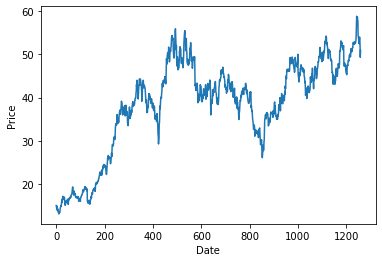

In [2]:
data_df['open'].plot()
plt.xlabel('Date') # set a xlabel
plt.ylabel('Price')

In [3]:
data_df.head(-10)

,date,open
0,2013/2/8,15.07
1,2013/2/11,14.89
2,2013/2/12,14.45
3,2013/2/13,14.30
4,2013/2/14,14.94
...,...,...
1244,2018/1/18,58.00
1245,2018/1/19,58.59
1246,2018/1/22,57.99
1247,2018/1/23,57.74


In [4]:
from sklearn.preprocessing import MinMaxScaler
data_rehsape = data_df['open'].values.reshape(-1,1).astype('float32')
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(data_rehsape)

In [5]:
look_back = 20
X = []
y = []
for i in range(look_back, 1258):  # 1258 是訓練集總數
    X.append(training_set_scaled[i-look_back:i, 0])
    y.append(training_set_scaled[i, 0])
X, y = np.array(X), np.array(y) 

In [6]:
X = X.reshape(X.shape[0], X.shape[1],1)

In [7]:
train_size = int(X.shape[0]*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (990, 20, 1)
X_test shape: (248, 20, 1)


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.layers import RepeatVector, TimeDistributed
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential


In [10]:
"""
ltnt_dim = 1
inpt_vec = Input(shape=(X_train.shape[1],X_train.shape[2],))
l1 = LSTM(X_train.shape[1]*4)(inpt_vec)
output = Dense(1, activation='linear')(l1)
lstm = Model(inpt_vec, output)
lstm.compile(loss='mse', optimizer='adam',metrics=['mse'])
lstm.summary()
"""

"\nltnt_dim = 1\ninpt_vec = Input(shape=(X_train.shape[1],X_train.shape[2],))\nl1 = LSTM(X_train.shape[1]*4)(inpt_vec)\noutput = Dense(1, activation='linear')(l1)\nlstm = Model(inpt_vec, output)\nlstm.compile(loss='mse', optimizer='adam',metrics=['mse'])\nlstm.summary()\n"

In [11]:
lstm = Sequential()
lstm.add(LSTM(look_back, input_shape=(look_back, 1)))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
#callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
patience=3,
min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=30,
restore_best_weights=True, verbose=1)
#training
hist = lstm.fit(X_train, y_train, batch_size=1, epochs=100,
callbacks=[stop_alg, reduce_lr], shuffle=False, validation_data=(X_test, y_test))

Train on 990 samples, validate on 248 samples
Epoch 1/100
990/990 [==============================] - 4s 4ms/sample - loss: 0.0019 - val_loss: 0.0054
Epoch 2/100
990/990 [==============================] - 2s 2ms/sample - loss: 0.0022 - val_loss: 0.0044
Epoch 3/100
990/990 [==============================] - 2s 2ms/sample - loss: 0.0019 - val_loss: 0.0039
Epoch 4/100
990/990 [==============================] - 2s 2ms/sample - loss: 0.0016 - val_loss: 0.0033
Epoch 5/100
990/990 [==============================] - 2s 2ms/sample - loss: 0.0014 - val_loss: 0.0029
Epoch 6/100
990/990 [==============================] - 2s 2ms/sample - loss: 0.0011 - val_loss: 0.0025
Epoch 7/100
990/990 [==============================] - 2s 2ms/sample - loss: 9.0306e-04 - val_loss: 0.0022
Epoch 8/100
990/990 [==============================] - 2s 2ms/sample - loss: 7.3668e-04 - val_loss: 0.0020
Epoch 9/100
990/990 [==============================] - 2s 2ms/sample - loss: 6.3234e-04 - val_loss: 0.0018
Epoch 10/100
99

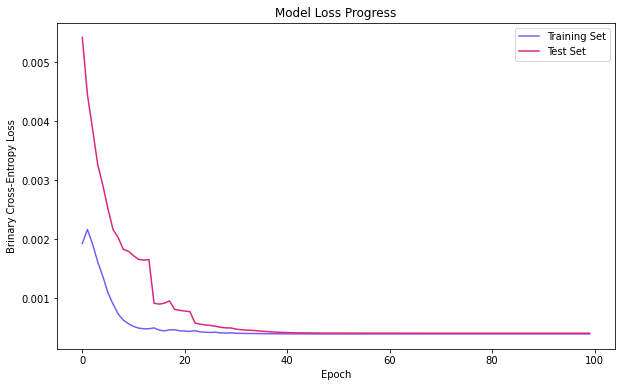

In [13]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Brinary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

#### train

In [14]:
y_hat = lstm.predict(X_train)

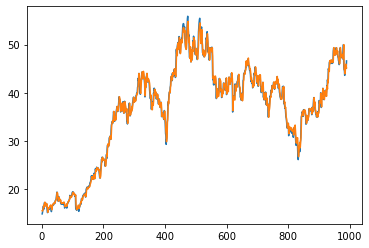

In [15]:
len_test = np.linspace(0, y_train.shape[0],y_train.shape[0]+1)
plt.plot(len_test[1:],sc.inverse_transform(y_train.reshape(-1,1)))
plt.plot(len_test[1:],sc.inverse_transform(y_hat))

#### test

In [27]:
y_hat = lstm.predict(X_test)

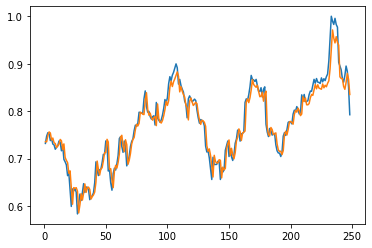

In [28]:
len_test = np.linspace(0, y_test.shape[0],y_test.shape[0]+1)
plt.plot(len_test[1:],y_test)
plt.plot(len_test[1:],y_hat)